# American Option Pricing with PINNs

## Introduction

This notebook demonstrates how to solve the pricing problem for **American put options** using **Physics-Informed Neural Networks (PINNs)**.

### What is an American Option?

An **American option** differs from a European option in one key way:
- It can be exercised **at any time before or at maturity**, not just at maturity.

This feature introduces a **free boundary problem** into the PDE — we don't know in advance where it's optimal to exercise the option.

### Pricing via the Black-Scholes PDE

The same Black-Scholes PDE applies:
$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + rS \frac{\partial V}{\partial S} - rV \leq 0
$$

But now we must also satisfy:
$$
V(S,t) \geq K - S
$$

This inequality turns the PDE into a **variational inequality**. Traditional methods like finite differences require special numerical techniques to handle this.

### PINNs with Penalty Method

We handle the inequality constraint softly by introducing a **penalty term** in the loss function. This lets the neural network learn where the constraint becomes active — in effect, it **learns the early exercise boundary** from the data and physics.


### Classical Approach: Finite Difference Methods (FDM)

Traditionally, American options are priced using grid-based methods such as the **finite difference method** (FDM), which discretizes the PDE over time and asset price.

However, the early exercise feature introduces a **free boundary problem**, requiring special numerical techniques such as:
- Projected successive over-relaxation (SOR),
- Penalty methods,
- Crank-Nicolson schemes with early exercise adjustments.

While effective, these methods require careful grid construction and boundary handling. In this notebook, we use a PINN to **learn** the early exercise behavior without explicitly modeling the boundary.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# --- American Put Option with PINN (Penalty Method) ---

class AmericanPINN(nn.Module):
    def __init__(self):
        super(AmericanPINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, S, t):
        return self.net(torch.cat([S, t], dim=1))

def bs_residual(model, S, t, r, sigma):
    S.requires_grad_(True)
    t.requires_grad_(True)

    V = model(S, t)
    V_t = torch.autograd.grad(V, t, torch.ones_like(V), create_graph=True)[0]
    V_S = torch.autograd.grad(V, S, torch.ones_like(V), create_graph=True)[0]
    V_SS = torch.autograd.grad(V_S, S, torch.ones_like(V), create_graph=True)[0]

    return V_t + 0.5 * sigma**2 * S**2 * V_SS + r * S * V_S - r * V

def payoff_put(S, K):
    return torch.clamp(K - S, min=0.0)

# Parameters
K = 10.0
T = 1.0
S_max = 15.0
r = 0.05
sigma = 0.25

# Generate training data
N_f, N_T, N_b = 10000, 200, 200
S_f = torch.rand(N_f, 1).to(device) * S_max
t_f = torch.rand(N_f, 1).to(device) * T

S_T = torch.linspace(0, S_max, N_T).view(-1, 1).to(device)
t_T = T * torch.ones_like(S_T).to(device)
V_T = payoff_put(S_T, K)

S_b = torch.cat([torch.zeros(N_b//2, 1), torch.ones(N_b//2, 1) * S_max], dim=0).to(device)
t_b = torch.rand(N_b, 1).to(device) * T
V_b = payoff_put(S_b, K)

# Train model
model = AmericanPINN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
lambda_penalty = 500.0
iterations = 5000

for epoch in range(iterations):
    optimizer.zero_grad()
    loss_pde = torch.mean(bs_residual(model, S_f, t_f, r, sigma)**2)
    loss_terminal = torch.mean((model(S_T, t_T) - V_T)**2)
    loss_boundary = torch.mean((model(S_b, t_b) - V_b)**2)
    penalty = torch.mean(torch.clamp(payoff_put(S_f, K) - model(S_f, t_f), min=0.0)**2)
    loss = loss_pde + loss_terminal + loss_boundary + lambda_penalty * penalty
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4e}, Penalty: {penalty.item():.4e}")

# Evaluate model
S_eval = torch.linspace(0, S_max, 500).view(-1, 1).to(device)
t_eval = torch.zeros_like(S_eval).to(device)
V_pred_PINN = model(S_eval, t_eval).detach().cpu().numpy()


Epoch 0, Loss: 1.2366e+04, Penalty: 2.4581e+01
Epoch 500, Loss: 5.5092e+01, Penalty: 1.0395e-02
Epoch 1000, Loss: 1.2660e+00, Penalty: 3.5101e-04
Epoch 1500, Loss: 6.9994e-01, Penalty: 1.5623e-04
Epoch 2000, Loss: 4.8671e-01, Penalty: 1.0012e-04
Epoch 2500, Loss: 3.7780e-01, Penalty: 6.4871e-05
Epoch 3000, Loss: 3.1019e-01, Penalty: 4.5746e-05
Epoch 3500, Loss: 2.6970e-01, Penalty: 3.3591e-05
Epoch 4000, Loss: 2.4443e-01, Penalty: 2.7566e-05
Epoch 4500, Loss: 2.2392e-01, Penalty: 2.3629e-05


In [3]:
# --- Finite Difference Method for American Put ---

def fdm_american_put(K, T, r, sigma, S_max, M=100, N=1000):
    dt = T / N
    dS = S_max / M
    S = np.linspace(0, S_max, M+1)
    V = np.maximum(K - S, 0)
    alpha = 0.25 * dt * (sigma**2 * (np.arange(M+1)**2) - r * np.arange(M+1))
    beta = -dt * 0.5 * (sigma**2 * (np.arange(M+1)**2) + r)
    gamma = 0.25 * dt * (sigma**2 * (np.arange(M+1)**2) + r * np.arange(M+1))

    A = np.zeros((M-1, M-1))
    for i in range(1, M):
        if i > 1:
            A[i-1, i-2] = -alpha[i]
        A[i-1, i-1] = 1 - beta[i]
        if i < M-1:
            A[i-1, i] = -gamma[i]

    B = np.zeros_like(A)
    for i in range(1, M):
        if i > 1:
            B[i-1, i-2] = alpha[i]
        B[i-1, i-1] = 1 + beta[i]
        if i < M-1:
            B[i-1, i] = gamma[i]

    for j in range(N):
        b = B @ V[1:-1]
        V_new = np.linalg.solve(A, b)
        V[1:-1] = np.maximum(V_new, K - S[1:-1])  # early exercise
    return S, V

S_fdm, V_fdm = fdm_american_put(K=K, T=1.0, r=0.05, sigma=0.25, S_max=S_max)


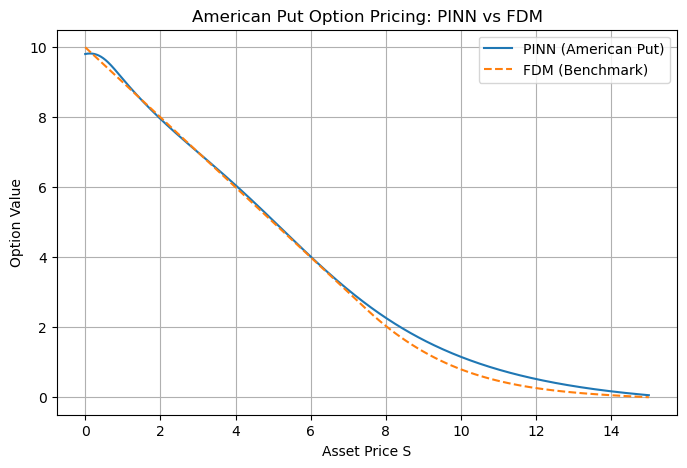

In [4]:
# --- Initial Comparison Plot: PINN vs Finite Difference ---
plt.figure(figsize=(8,5))
plt.plot(S_eval.cpu().numpy(), V_pred_PINN, label='PINN (American Put)')
plt.plot(S_fdm, V_fdm, '--', label='FDM (Benchmark)')
plt.xlabel('Asset Price S')
plt.ylabel('Option Value')
plt.title('American Put Option Pricing: PINN vs FDM')
plt.legend()
plt.grid(True)
plt.show()


In [5]:
def fdm_american_put_full(K, T, r, sigma, S_max, M=100, N=1000):
    dt = T / N
    dS = S_max / M
    S = np.linspace(0, S_max, M+1)
    t = np.linspace(0, T, N+1)

    # Initialize solution matrix: rows = time steps, cols = space steps
    V = np.zeros((N+1, M+1))
    V[0, :] = np.maximum(K - S, 0)  # terminal payoff at t = T

    alpha = 0.25 * dt * (sigma**2 * (np.arange(M+1)**2) - r * np.arange(M+1))
    beta = -dt * 0.5 * (sigma**2 * (np.arange(M+1)**2) + r)
    gamma = 0.25 * dt * (sigma**2 * (np.arange(M+1)**2) + r * np.arange(M+1))

    A = np.zeros((M-1, M-1))
    for i in range(1, M):
        if i > 1:
            A[i-1, i-2] = -alpha[i]
        A[i-1, i-1] = 1 - beta[i]
        if i < M-1:
            A[i-1, i] = -gamma[i]

    B = np.zeros_like(A)
    for i in range(1, M):
        if i > 1:
            B[i-1, i-2] = alpha[i]
        B[i-1, i-1] = 1 + beta[i]
        if i < M-1:
            B[i-1, i] = gamma[i]

    # Step backward in time, saving each step
    for j in range(1, N+1):
        b = B @ V[j-1, 1:-1]
        V_new = np.linalg.solve(A, b)
        V[j, 1:-1] = np.maximum(V_new, K - S[1:-1])  # enforce early exercise
        V[j, 0] = K  # boundary condition at S=0
        V[j, -1] = 0  # boundary condition at S=S_max

    return S, t, V


In [6]:
S_fdm, t_fdm, V_fdm_full = fdm_american_put_full(K=K, T=T, r=r, sigma=sigma, S_max=S_max)
V_fdm_flipped = np.flip(V_fdm_full, axis=0)  # flip so t=0 is first row (to match PINN convention)

S_tensor = torch.tensor(S_fdm, dtype=torch.float32).view(-1, 1).to(device)
t_tensor = torch.tensor(t_fdm, dtype=torch.float32).view(-1, 1).to(device)

S_mesh, t_mesh = torch.meshgrid(S_tensor.squeeze(), t_tensor.squeeze(), indexing='ij')
S_flat = S_mesh.reshape(-1, 1)
t_flat = t_mesh.reshape(-1, 1)

V_PINN_flat = model(S_flat, t_flat).detach().cpu().numpy()
V_PINN_grid = V_PINN_flat.reshape(S_mesh.shape)


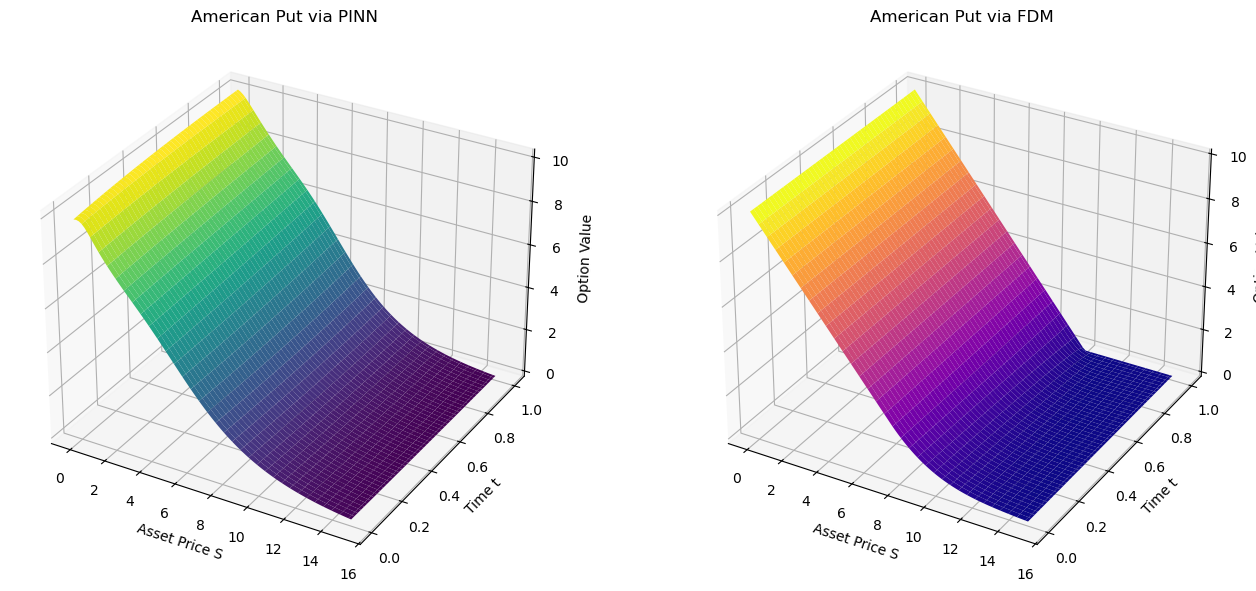

In [7]:
fig = plt.figure(figsize=(14, 6))

# PINN plot
S_mesh_plot = np.asarray(S_mesh.cpu().numpy(), dtype=np.float32)
t_mesh_plot = np.asarray(t_mesh.cpu().numpy(), dtype=np.float32)
V_PINN_plot = np.asarray(V_PINN_grid, dtype=np.float32)

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(S_mesh_plot, t_mesh_plot, V_PINN_plot, cmap='viridis')

#ax1.plot_surface(S_mesh.cpu().numpy(), t_mesh.cpu().numpy(), V_PINN_grid, cmap='viridis')
ax1.set_title("American Put via PINN")
ax1.set_xlabel("Asset Price S")
ax1.set_ylabel("Time t")
ax1.set_zlabel("Option Value")

# FDM plot (FIXED)
S_mesh_fdm, t_mesh_fdm = np.meshgrid(S_fdm, t_fdm, indexing='ij')
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(S_mesh_fdm, t_mesh_fdm, V_fdm_flipped.T, cmap='plasma')
ax2.set_title("American Put via FDM")
ax2.set_xlabel("Asset Price S")
ax2.set_ylabel("Time t")
ax2.set_zlabel("Option Value")

plt.tight_layout()
plt.show()


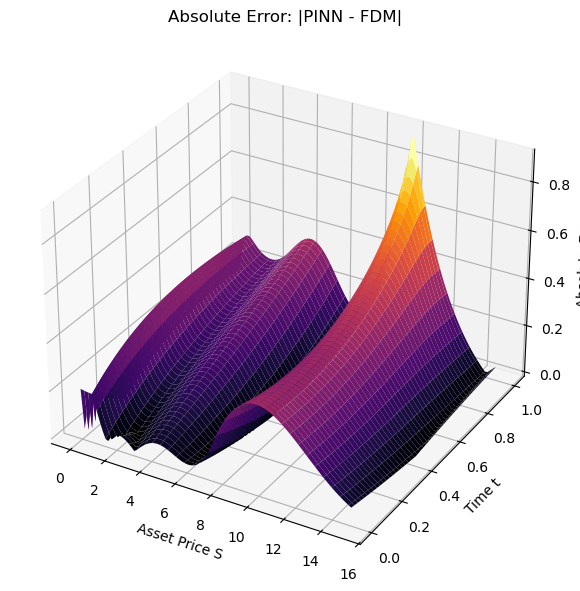

In [8]:
# Absolute difference surface
V_PINN_clean = np.asarray(V_PINN_grid, dtype=np.float32)
V_FDM_clean = np.asarray(V_fdm_flipped.T, dtype=np.float32)
error_surface = np.abs(V_PINN_clean - V_FDM_clean)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(S_mesh_fdm, t_mesh_fdm, error_surface, cmap='inferno')
ax.set_title("Absolute Error: |PINN - FDM|")
ax.set_xlabel("Asset Price S")
ax.set_ylabel("Time t")
ax.set_zlabel("Absolute Error")
plt.tight_layout()
plt.show()


In [9]:
S_vals = torch.linspace(0, S_max, 10000).to(device)
t_vals = torch.linspace(0, T, 1000).to(device)

exercise_boundary = []

for t_val in t_vals:
    t_grid = t_val.repeat(S_vals.shape[0], 1)
    S_grid = S_vals.view(-1, 1)

    V = model(S_grid, t_grid).detach().cpu().numpy().flatten()
    payoff = payoff_put(S_grid, K).detach().cpu().numpy().flatten()

    # Find index where V - payoff is closest to 0 from above (transition point)
    diff = V - payoff
    mask = diff > 1e-3  # slightly above payoff
    if np.any(mask):
        idx = np.argmax(mask)  # first point where model is just above payoff
        exercise_boundary.append((t_val.item(), S_vals[idx].item()))
    else:
        exercise_boundary.append((t_val.item(), 0.0))  # fallback if no boundary found


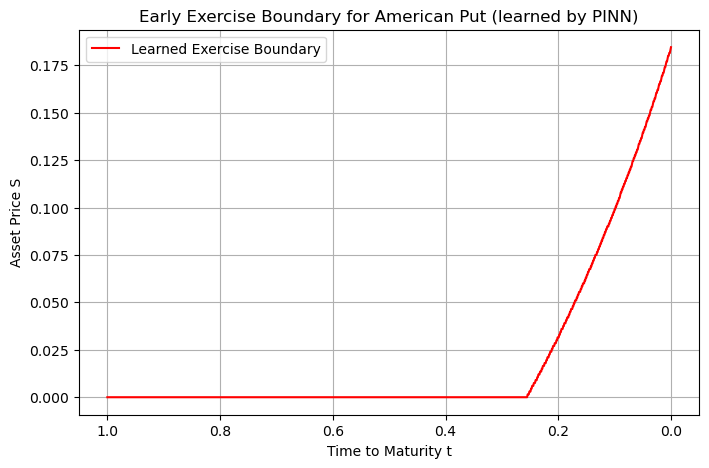

In [10]:
exercise_boundary = np.array(exercise_boundary)
plt.figure(figsize=(8, 5))
plt.plot(exercise_boundary[:, 0], exercise_boundary[:, 1], label="Learned Exercise Boundary", color='red')
plt.xlabel("Time to Maturity t")
plt.ylabel("Asset Price S")
plt.title("Early Exercise Boundary for American Put (learned by PINN)")
plt.gca().invert_xaxis()  # time runs backwards
plt.grid(True)
plt.legend()
plt.show()

## Conclusion

We have used a PINN with a penalty method to approximate the value of an American put option.

- The PINN learns both the PDE solution and the inequality constraint simultaneously.
- It naturally discovers the **early exercise boundary** without explicitly modeling it.
- Compared to finite difference methods, this offers a flexible and mesh-free alternative, especially useful in higher dimensions.

This approach demonstrates how neural networks can solve classical finance problems in a novel and insightful way.
